In [1]:
from umap import UMAP
from datasets import load_dataset
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from datetime import datetime
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from nltk.corpus import stopwords
import string
import nltk

c:\Users\anthonyhevia\Desktop\code\datamatters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("nedjmaou/MLMA_hate_speech")
tweets = dataset['train']['tweet']

In [3]:
targets=dataset['train']['target']

In [4]:
# For illustration purposes, we make sure the output is fixed when running this code multiple times
umap_model = UMAP(metric='cosine', random_state=420)

# We can choose any number of seed words for which we want their representation
# to be strengthen. We increase the importance of these words as we want them to be more
# likely to end up in the topic representations.
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True
)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

hdbscan_model = HDBSCAN(metric='euclidean', cluster_selection_method='eom', prediction_data=True)

vectorizer_model = CountVectorizer(stop_words="english")

# The main representation of a topic
main_representation = KeyBERTInspired()

# Additional ways of representing a topic
aspect_model1 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": main_representation,
   "Aspect1":  aspect_model1,
}

In [5]:
# Define stop words and punctuation
stop_words = set(stopwords.words('english')).union(set(stopwords.words('arabic'))).union(set(stopwords.words('french')))
punctuation = set(string.punctuation)
custom_stop_words = set(["user", "y'all", "ur", "url", "ok", "oh", "lol", "lmao", "....."])
remove_words = stop_words.union(punctuation).union(custom_stop_words)

# Tokenize tweets and remove stop words and punctuation
tokenized_tweets = [
    [word for word in nltk.word_tokenize(tweet.lower()) if word not in remove_words and word not in punctuation]
    for tweet in tweets
]

# Rejoin the tweets into sentences
cleaned_tweets = [" ".join(tweet) for tweet in tokenized_tweets]

In [6]:
cleaned_tweets

['صلاة الفجر خير ترديد بول البعير وسبي النساء واغتصاب طفلة نظافة ونشاط وحيوية عقلانيون',
 'نفسي اشوف ولاد الوسخة اللي قالوا مدرب اجنبي منك لله ربنا ياخدك ي…',
 'طيب متبرجة وعبايتها ملونه وطالعة بيتهم بدون .......',
 'انا اوافقك بخصوص السوريين العراقيين اما بخصوص السعودي مو بحاجه انه يقعد بالكويت بدو…',
 'السعودية شعبها شعب الخيم بول البعير يستهزأ الناس',
 'عارف كنت شايفها منحرفة شديد وانا صغير ليه',
 'تخيل يرد يقولك معلوماتنا ان سكان الارض يشربون بول البعير',
 'التوكل الله والسعي رزقه والثقة عنده افريقيا_يا_اهلى',
 'وانتي مال امك مطلقة بايرة ياوش قنوات',
 'الكردي كلب يوم يومه بحاجة دائما لسيد وهلا اصبحتم خنازير اسرائيل بمرتبة الكلب',
 'مدعمتهاش ليه فى كاس العالم جبان وسخ',
 'خنازير فعلت فعلاً ..',
 'حرمة متبرجة تقف المسرح وتغني امام الر…',
 'ابن سلمان ابن ملك بن ملك معروف جد لاب الام رجال قهر خنازير المجوس وذنابها.…',
 'قصارية بايرة',
 'يارب انصرنا افريقيا_يا_اهلي',
 'واضح انكم تكذبوها سالفه ان الحريم يقعدن بالارض انا فهمت غلط ودرعمت؟',
 'واحده بايره',
 'اعراب همج ايش تتوقع شاربين بول 

In [ ]:
# We run the topic model with the seeded words
topic_model = BERTopic(
    nr_topics=5,
    umap_model=umap_model,
    ctfidf_model=ctfidf_model,
    embedding_model=embedding_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model
).fit(cleaned_tweets)

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=5,
                                            topic_prefix=True,
                                            word_length=10,
                                            separator=", ")

In [ ]:
topic_model.set_topic_labels(topic_labels)
topic_model.custom_labels_


In [7]:
# Create the unique model path with the current date
model_path = f"./output/hate_speech_topic_model"

In [ ]:
# Save the topic model
topic_model.save(model_path, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [8]:
topic_model = BERTopic.load(model_path, embedding_model=embedding_model)

In [ ]:
topic_model.get_topic_info()

In [9]:
topic_model.visualize_documents(cleaned_tweets)

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_topics()

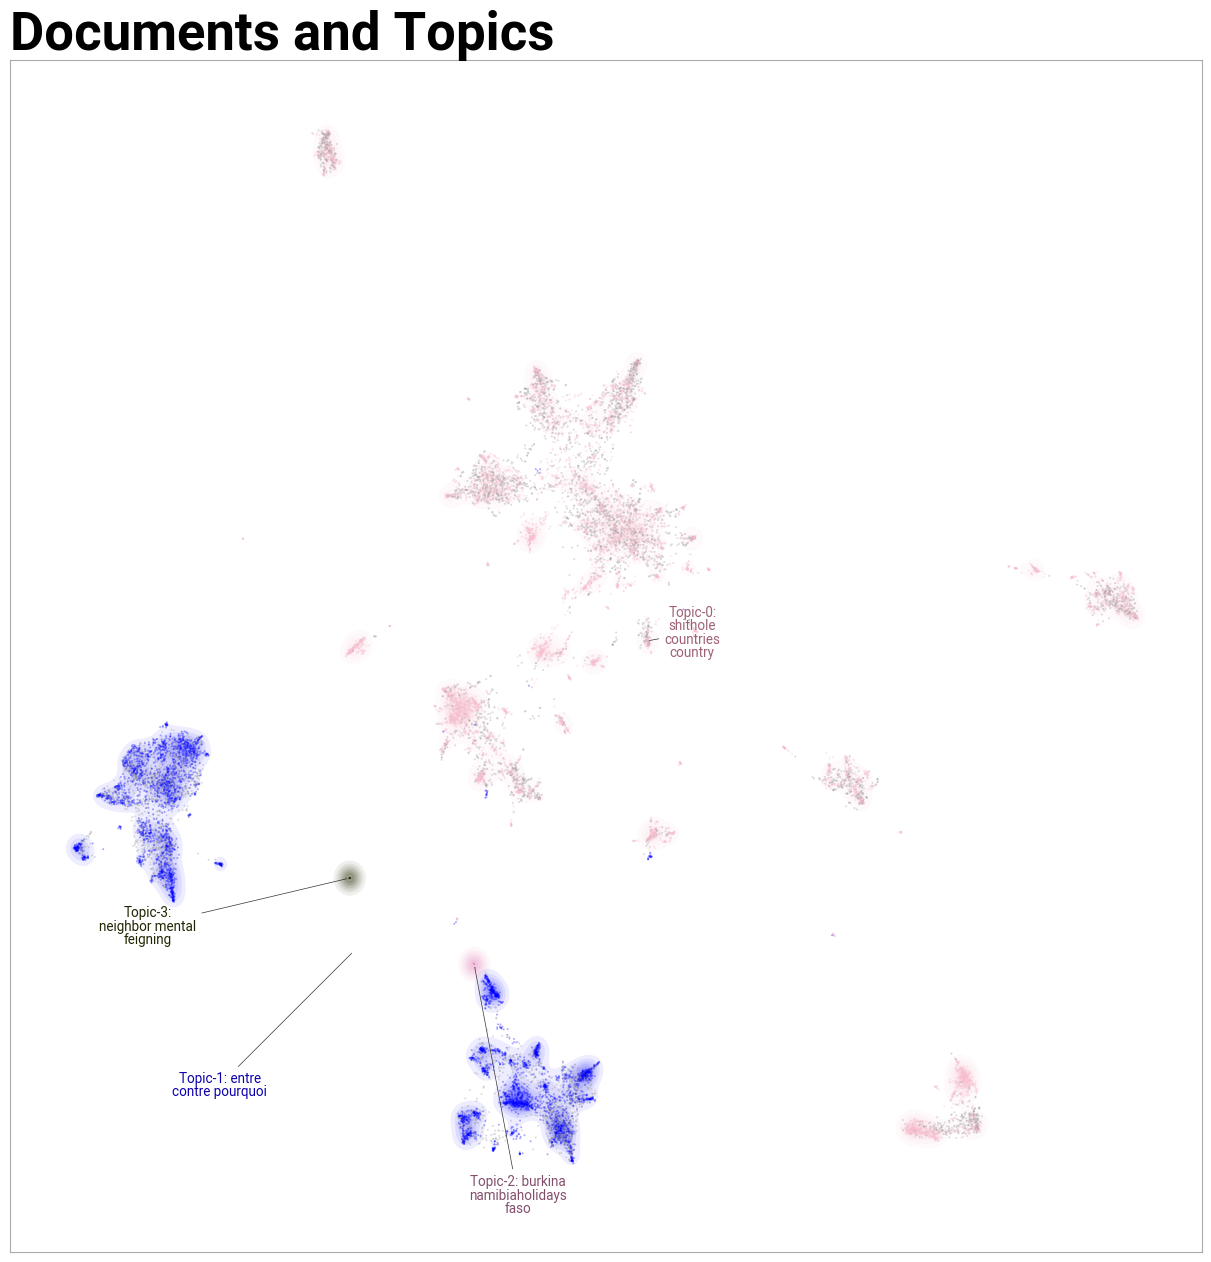

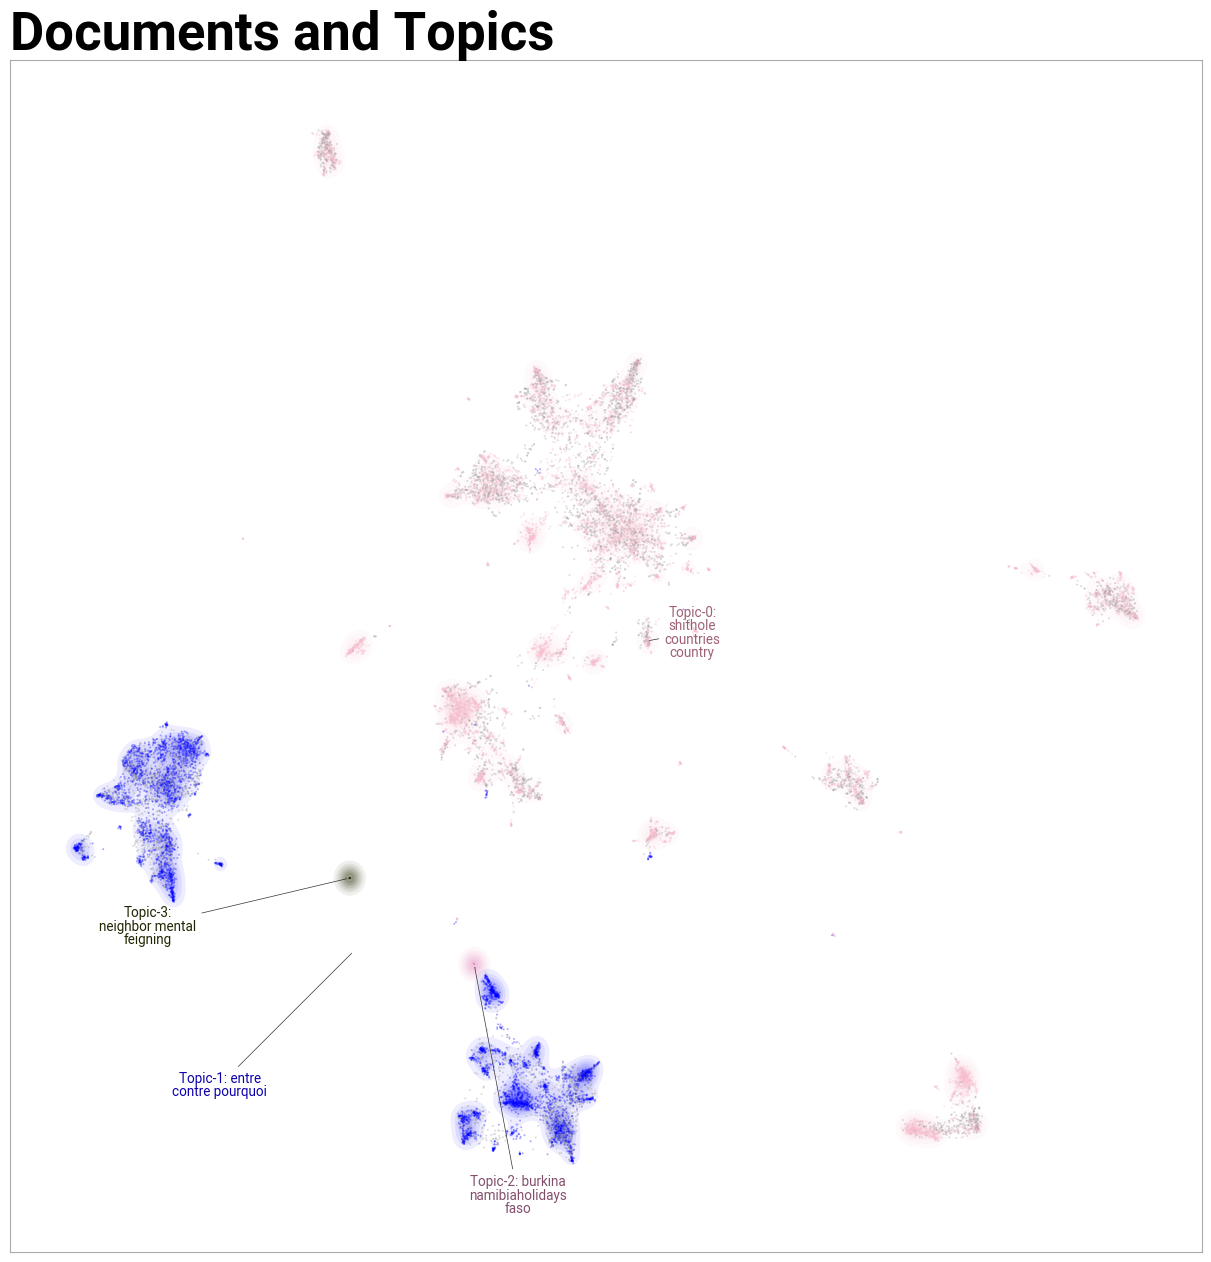

In [11]:
topic_model.visualize_document_datamap(cleaned_tweets)

In [ ]:
topic_model.visualize_barchart()

In [10]:
topics_per_class = topic_model.topics_per_class(cleaned_tweets, classes=targets)
topic_model.visualize_topics_per_class(topics_per_class)